# Functions and stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import json
import time #to delay exectutions

import cmdstanpy
import arviz as az
az.style.use('arviz-darkgrid')
!jupyter nbextension enable --py widgetsnbextension

np.set_printoptions(suppress=True)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.39ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 2.2.1pop0-1628521831-21.10-5dbe6cf is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
cwd = os.getcwd()
stan_directory = '~/.cmdstan/cmdstan-2.29.2'
data_dir = 'data/FK'

In [100]:
def plot_PKpriors(CL, Q, VC, VP, ka) :

    fig, ax = plt.subplots(ncols=5, figsize=(10, 2))
 
    az.plot_density(CL, ax=ax[0], point_estimate='median')
    az.plot_density(Q, ax=ax[1], point_estimate='median')
    az.plot_density(VC, ax=ax[2], point_estimate='median')
    az.plot_density(VP, ax=ax[3], point_estimate='median')
    az.plot_density(ka, ax=ax[4], point_estimate='median') 

    for i in range(5) :
        ax[i].set_title(str(['CL pop', 'Q pop', 'VC pop', 'VP pop', 'ka pop'][i]))
    plt.show()
    
    
def plot_PDpriors(mtt, circ0, gamma, alpha) :
    
    fig, ax = plt.subplots(ncols=4, figsize=(10, 2))

    az.plot_density(mtt, ax=ax[0], point_estimate='median')
    az.plot_density(circ0, ax=ax[1], point_estimate='median')
    az.plot_density(alpha, ax=ax[2], point_estimate='median')
    az.plot_density(gamma, ax=ax[3], point_estimate='median')
    
    for i in range(4) :
        ax[i].set_title(str(['mtt pop', 'circ0 pop', 'alpha pop', 'gamma pop'][i]))
    plt.show()
    
    
def plot_compare(prior_list, posterior_list, names=None) :

    fig, ax = plt.subplots(ncols=len(prior_list), figsize=(16, 4))
    
    for i in range(len(prior_list)) :
        line1 = az.plot_density(prior_list[i], ax=ax[i], point_estimate=None, colors=['blue'], shade=.3)
        line2 = az.plot_density(posterior_list[i], ax=ax[i], point_estimate=None, colors=['red'], shade=.3)
        if names is not None :
            ax[i].set_title(str(names[i]))
    plt.show()

In [67]:

def plot_ppc_mle(mle_vars, nsub, data_dir, data_prefix, figsize=(8, 4)) :

    with open(data_dir + '/' + data_prefix + '.data.json', 'r') as f:
      datajson = json.load(f)

    nt = datajson['nt']
    tPK = np.array(datajson['timePK'])
    cObs = np.array(datajson['cObs'])
    tPD = np.array(datajson['timePD'])
    neutObs = np.array(datajson['neutObs'])
    
    fig, ax = plt.subplots(nrows=2, ncols=nsub, figsize=figsize)
    
    for i in range(nsub) :

        ind = i
        PKstart = datajson['startPK'][ind]-1
        PKend = datajson['endPK'][ind]
        PDobs1 = datajson['startPD'][ind]-1
        PDobs2 = datajson['endPD'][ind]

        ax[0][i].plot(tPK[PKstart:PKend], mle_vars['cPred'][0:(PKend-PKstart)], '-', label='pred')
        ax[0][i].plot(tPK[PKstart:PKend], cObs[PKstart:PKend], 'o-', label='obs')
        ax[0][i].set_title('ind ' + str(i) + ' | weight = 70')
        ax[0][i].legend()

        ax[1][i].plot(tPD[PDobs1:PDobs2], mle_vars['neutHatObs'][PDobs1:PDobs2], '-', label='hat')
        ax[1][i].plot(tPD[PDobs1:PDobs2], neutObs[PDobs1:PDobs2], 'o-', label='obs')
    
 
    
def plot_ppc_az(az_chains, nsub, figsize=(10, 2)) :
 
    cPred_ind = az_chains.posterior_predictive['cPred_ind']
    cPred_pop = az_chains.posterior_predictive['cPred_pop']
    neutPred_ind = az_chains.posterior_predictive['neutPred_ind']
    neutPred_pop = az_chains.posterior_predictive['neutPred_pop']
    t = az_chains.observed_data['time']
    tPK = az_chains.observed_data['timePK']
    tPD = az_chains.observed_data['timePD']

    fig, ax = plt.subplots(nrows=2, ncols=nsub, figsize=figsize) 

    for i in range(nsub) :

        wt = np.array(az_chains.observed_data['weight'][i])
        PKstart = int(az_chains.observed_data['startPK'][i]-1)
        PKend = int(az_chains.observed_data['endPK'][i])
        PDstart = int(az_chains.observed_data['startPD'][i]-1)
        PDend = int(az_chains.observed_data['endPD'][i])
        start = int(az_chains.observed_data['start'][i])
        end = int(az_chains.observed_data['end'][i])

        
        cPred_ind_i = cPred_ind[:, :, start:end]
        c_qlow_ind = np.quantile(cPred_ind_i, 0.05, axis=[0,1])
        c_qhigh_ind = np.quantile(cPred_ind_i, 0.975, axis=[0,1])
        
        cPred_pop_i = cPred_pop[:, :, start:end]
        c_qlow_pop = np.quantile(cPred_pop_i, 0.05, axis=[0,1])
        c_qhigh_pop = np.quantile(cPred_pop_i, 0.975, axis=[0,1])

        ax[0][i].plot(tPK[PKstart:PKend], cPred_ind_i.mean(axis=0).mean(axis=0)[0:(PKend-PKstart)],
                   color='red', label='ind pred') 
        ax[0][i].fill_between(tPK[PKstart:PKend], 
                              c_qlow_ind[0:(PKend-PKstart)], 
                              c_qhigh_ind[0:(PKend-PKstart)], 
                              alpha=0.2, color='red', label='95% CI')
        
        ax[0][i].plot(tPK[PKstart:PKend], cPred_pop_i.mean(axis=0).mean(axis=0)[0:(PKend-PKstart)],
                   color='blue', label='pop pred') 
        ax[0][i].fill_between(tPK[PKstart:PKend], 
                              c_qlow_pop[0:(PKend-PKstart)], 
                              c_qhigh_pop[0:(PKend-PKstart)], 
                              alpha=0.2, color='blue', label='95% CI')
        
        ax[0][i].plot(tPK[PKstart:PKend], az_chains.observed_data['cObs'][PKstart:PKend], 
                   '-o', markersize=3, color='black', label='obs')
        

        ax[0][i].set_title('ind ' + str(i+1) + ' | weight = ' + str(np.round(wt, 1)))

   
        neutPred_ind_i = neutPred_ind[:, :, start:end]
        neut_qlow_ind = np.quantile(neutPred_ind_i, 0.05, axis=[0,1])
        neut_qhigh_ind = np.quantile(neutPred_ind_i, 0.975, axis=[0,1])
        
        neutPred_pop_i = neutPred_pop[:, :, start:end]
        neut_qlow_pop = np.quantile(neutPred_pop_i, 0.05, axis=[0,1])
        neut_qhigh_pop = np.quantile(neutPred_pop_i, 0.975, axis=[0,1])

        ax[1][i].plot(t[start:end], neutPred_ind_i.mean(axis=0).mean(axis=0), 
                      color='red', label='ind pred')   
        ax[1][i].fill_between(t[start:end], 
                              neut_qlow_ind, 
                              neut_qhigh_ind, 
                              alpha=0.2, color='red', label='95% CI')

        ax[1][i].plot(t[start:end], neutPred_pop_i.mean(axis=0).mean(axis=0), 
                      color='blue', label='pop pred')   
        ax[1][i].fill_between(t[start:end], 
                              neut_qlow_pop, 
                              neut_qhigh_pop, 
                              alpha=0.2, color='blue', label='95% CI')
        
        ax[1][i].plot(tPD[PDstart:PDend], az_chains.observed_data['neutObs'][PDstart:PDend],
                     '-o', markersize=3, color='black', label='obs')

    ax[0][0].set_ylabel('Concentration')
    ax[1][0].set_ylabel('Abs. neutrophil count')
    ax[0][0].legend()
    
    plt.show()

# Priors on parameters

**True values :**

* CL_pop = 10, Q_pop = 15, VC_pop = 35, VP_pop = 105, KA_pop = 2.0

* mtt_pop = 125, circ0_pop = 5, gamma_pop = 0.17, alpha_pop = 0.01

At first, FK_less_info model had very wide priors sd=10 not taking into account the log scale, 
yet mle was still performing alright. Changed these priors were changer to sd of log(5) to be reasonably informative.


More stable and accurate estimation of parameters when changing variance priors. Changed variance priors to $\omega \sim Cauchy(0, 0.5)$ (reduced sd) and $sigma \sim N(0, 0.1)$ (previously Cauchy) and estimation of parameters drastically improved.

### Relatively informative PK priors

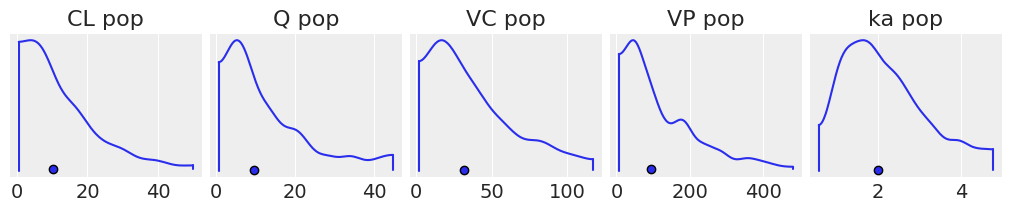

In [72]:
CLpop_prior = np.random.lognormal(mean=np.log(10), sigma=1, size=500)
Qpop_prior = np.random.lognormal(mean=np.log(10), sigma=1, size=500)
VCpop_prior = np.random.lognormal(mean=np.log(30), sigma=1, size=500)
VPpop_prior = np.random.lognormal(mean=np.log(100), sigma=1, size=500)
kapop_prior = np.random.lognormal(mean=np.log(2), sigma=0.5, size=500)

plot_PKpriors(CLpop_prior, Qpop_prior, VCpop_prior, VPpop_prior, kapop_prior)

### Wider PK priors

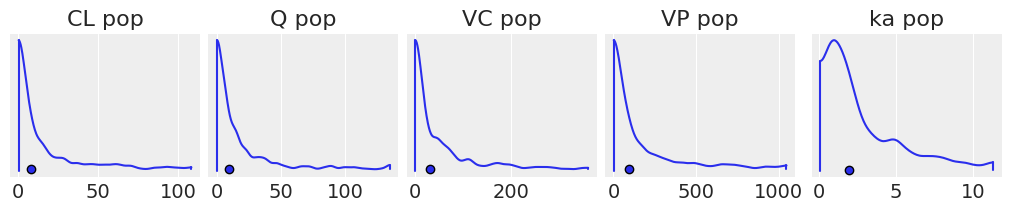

In [75]:
CLpop_prior = np.random.lognormal(mean=np.log(10), sigma=np.log(5), size=500)
Qpop_prior = np.random.lognormal(mean=np.log(10), sigma=np.log(5), size=500)
VCpop_prior = np.random.lognormal(mean=np.log(30), sigma=np.log(5), size=500)
VPpop_prior = np.random.lognormal(mean=np.log(100), sigma=np.log(5), size=500)
kapop_prior = np.random.lognormal(mean=np.log(2), sigma=1, size=500)

plot_PKpriors(CLpop_prior, Qpop_prior, VCpop_prior, VPpop_prior, kapop_prior)

### PD priors

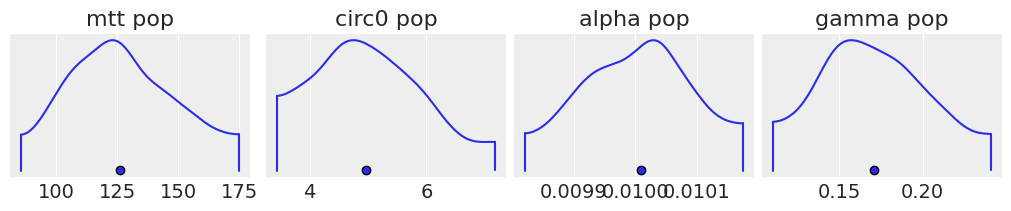

In [101]:
circ0pop_prior = np.random.lognormal(mean=np.log(5), sigma=0.2, size=500)
mttpop_prior = np.random.lognormal(mean=np.log(125), sigma=0.2, size=500)
gammapop_prior = np.random.lognormal(mean=np.log(0.17), sigma=0.2, size=500)
alphapop_prior = np.random.lognormal(mean=np.log(0.01), sigma=0.01, size=500)

plot_PDpriors(mttpop_prior, circ0pop_prior, gammapop_prior, alphapop_prior)

# MLE

## FK model with 2 subjects

In [302]:
data_prefix = 'fribergKarlsson_2sub_neutro'
data_file = data_prefix + '.data.R'
init_file = data_prefix + '.init.R'

### MLE with informative PK priors : good estimation of parameters and good ppc

In [303]:
model = 'FK_neutro'
mle_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [304]:
mle_fit = mle_model.optimize(data=data_dir + '/' + data_file, inits=data_dir+'/'+init_file)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [305]:
mle = mle_fit.stan_variables()
print(mle['THETA_pop'])
print(mle['ka_pop'], mle['gamma_pop'])
print(mle['sigma'], mle['sigmaNeut'])

[  8.96318     11.6981      42.8047     115.952      128.871
   4.87576      0.00999948]
2.27346 0.165699
0.0916151 0.0717078


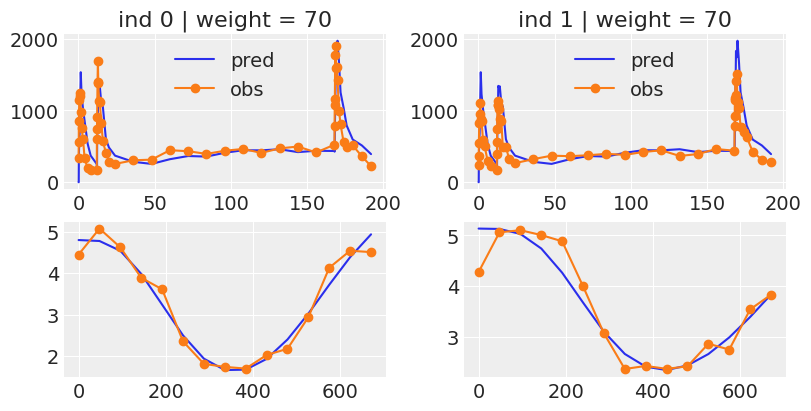

In [306]:
plot_ppc_mle(mle, 2, data_dir, data_prefix)

### MLE with wider priors :  good estimation of parameters and good ppc

In [307]:
model = 'FK_neutro_less_info'
mle_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [308]:
mle_fit = mle_model.optimize(data=data_dir + '/' + data_file, inits=data_dir+'/'+init_file)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [309]:
mle = mle_fit.stan_variables()
print(mle['THETA_pop'])
print(mle['ka_pop'], mle['gamma_pop'])
print(mle['sigma'], mle['sigmaNeut'])

[  8.84703     13.2859      45.6774     123.098      138.428
   5.45462      0.00999833]
2.26598 0.247242
0.0916388 0.444304


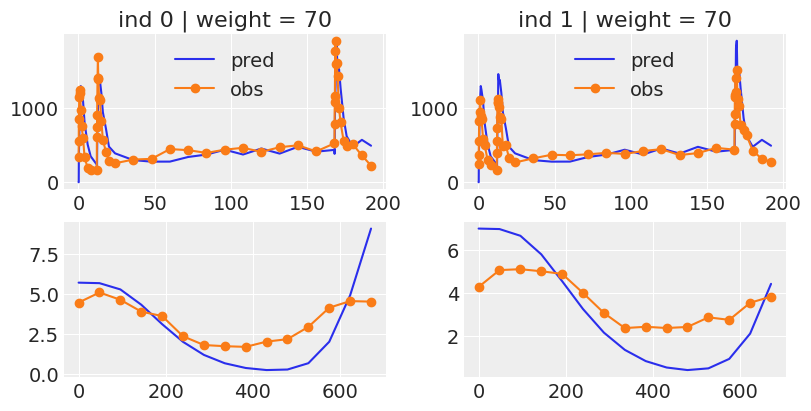

In [310]:
plot_ppc_mle(mle, 2, data_dir, data_prefix)

## Two compartments model with 5 subjects of different weight

In [311]:
data_prefix = 'fribergKarlsson_5sub_neutro'
data_file = data_prefix + '.data.R'
init_file = data_prefix + '.init.R'

### MLE with informative priors: almost perfect estimation of parameters and good ppc

In [312]:
model = 'FK_neutro'
mle_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [313]:
mle_fit = mle_model.optimize(data=data_dir + '/' + data_file, inits=data_dir+'/'+init_file)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [314]:
mle = mle_fit.stan_variables()
print(mle['THETA_pop'])
print(mle['ka_pop'], mle['gamma_pop'])
print(mle['sigma'], mle['sigmaNeut'])

[  7.63038     11.9192      31.6373     101.316      122.493
   4.98497      0.00999926]
1.88679 0.166472
0.0933506 0.0748341


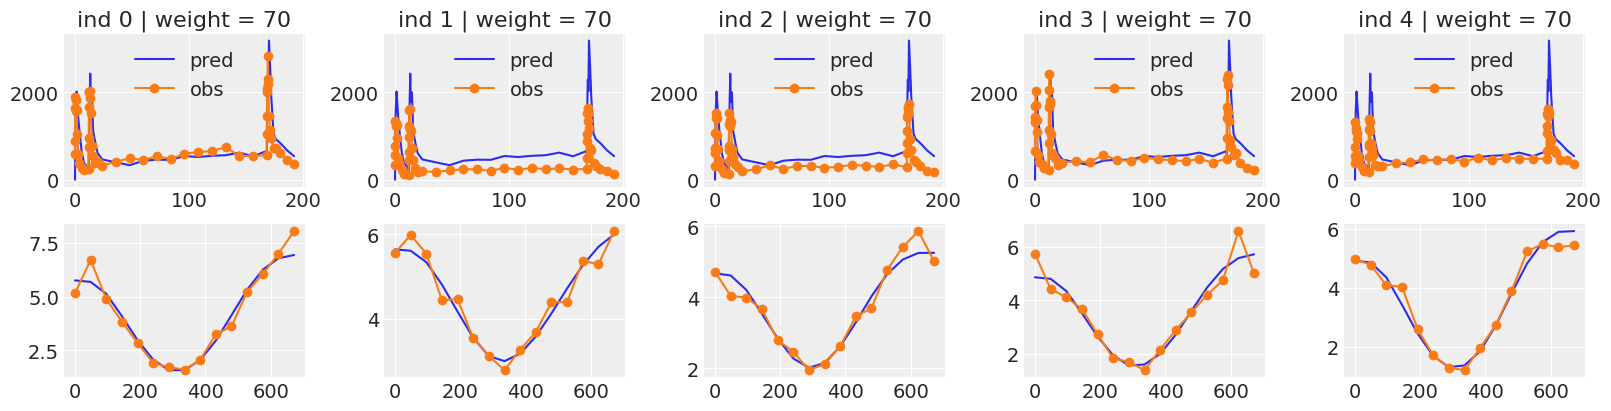

In [315]:
plot_ppc_mle(mle, 5, data_dir, data_prefix, figsize=(16, 4))

### MLE with wider priors: almost perfect estimation of parameters and a less good ppc for FK

In [316]:
model = 'FK_neutro_less_info'
mle_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [317]:
mle_fit = mle_model.optimize(data=data_dir + '/' + data_file, inits=data_dir+'/'+init_file)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [318]:
mle = mle_fit.stan_variables()
print(mle['THETA_pop'])
print(mle['ka_pop'], mle['gamma_pop'])
print(mle['sigma'], mle['sigmaNeut'])

[  8.6997      12.0741      27.8367     103.17       105.176
   5.2904       0.00999715]
1.87547 0.158392
0.0933712 0.557825


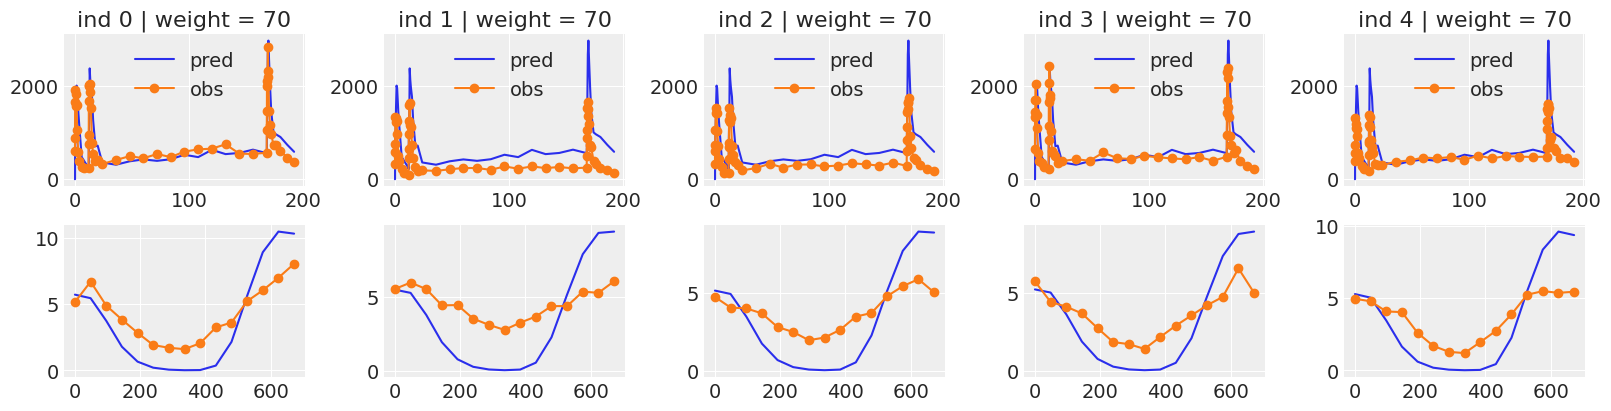

In [319]:
plot_ppc_mle(mle, 5, data_dir, data_prefix, figsize=(16, 4))

# HMC 5 individuals

In [23]:
data_prefix = 'fribergKarlsson_5sub_neutro'
data_file = data_prefix + '.data.R'
init_file = data_prefix + '.init.R'

In [24]:
model = 'FK_neutro_less_info'
hmc_model = cmdstanpy.CmdStanModel(model_name='FKdata', stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [25]:
fit_foldername="output_hmc_" + model + '5sub_1500'
fit_filename="output_hmc_" + model 
output_dir= cwd + "/" + fit_foldername

In [26]:
! mkdir -p $output_dir
! rm $output_dir/*

rm: cannot remove '/home/tng/Documents/PremiersEssais/Population/twoCpt/output_hmc_FK_neutro_less_info5sub_1500/*': No such file or directory


In [27]:
hmc_fit = hmc_model.sample(data=data_dir+'/'+data_file, inits=data_dir+'/'+init_file,
                        chains=2, iter_warmup=1000, iter_sampling=500, save_warmup=0, 
                        show_progress=True, output_dir=output_dir)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [33]:
hmc_fit.summary().head(10)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,590.00,0.660000,8.100000,580.0000,590.00,610.00,150.0,0.0079,1.0
CL_pop,9.60,0.085000,1.500000,7.5000,9.50,12.00,320.0,0.0170,1.0
Q_pop,15.00,0.320000,6.200000,8.9000,14.00,25.00,360.0,0.0190,1.0
VC_pop,33.00,0.460000,9.000000,23.0000,32.00,47.00,380.0,0.0200,1.0
VP_pop,120.00,0.830000,17.000000,97.0000,120.00,150.00,400.0,0.0210,1.0
mtt_pop,110.00,0.360000,7.500000,100.0000,110.00,130.00,430.0,0.0230,1.0
circ0_pop,5.10,0.016000,0.410000,4.5000,5.10,5.80,640.0,0.0340,1.0
alpha_pop,0.01,0.000002,0.000098,0.0098,0.01,0.01,2000.0,0.1000,1.0
ka_pop,1.90,0.003300,0.120000,1.7000,1.90,2.10,1400.0,0.0720,1.0


In [29]:
chains = az.from_cmdstan(output_dir + '/*' + '.csv', 
                         observed_data= data_dir + '/' + data_file,
                         posterior_predictive=['cPred_pop', 'cPred_ind', 'neutPred_pop', 'neutPred_ind'])
chains

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

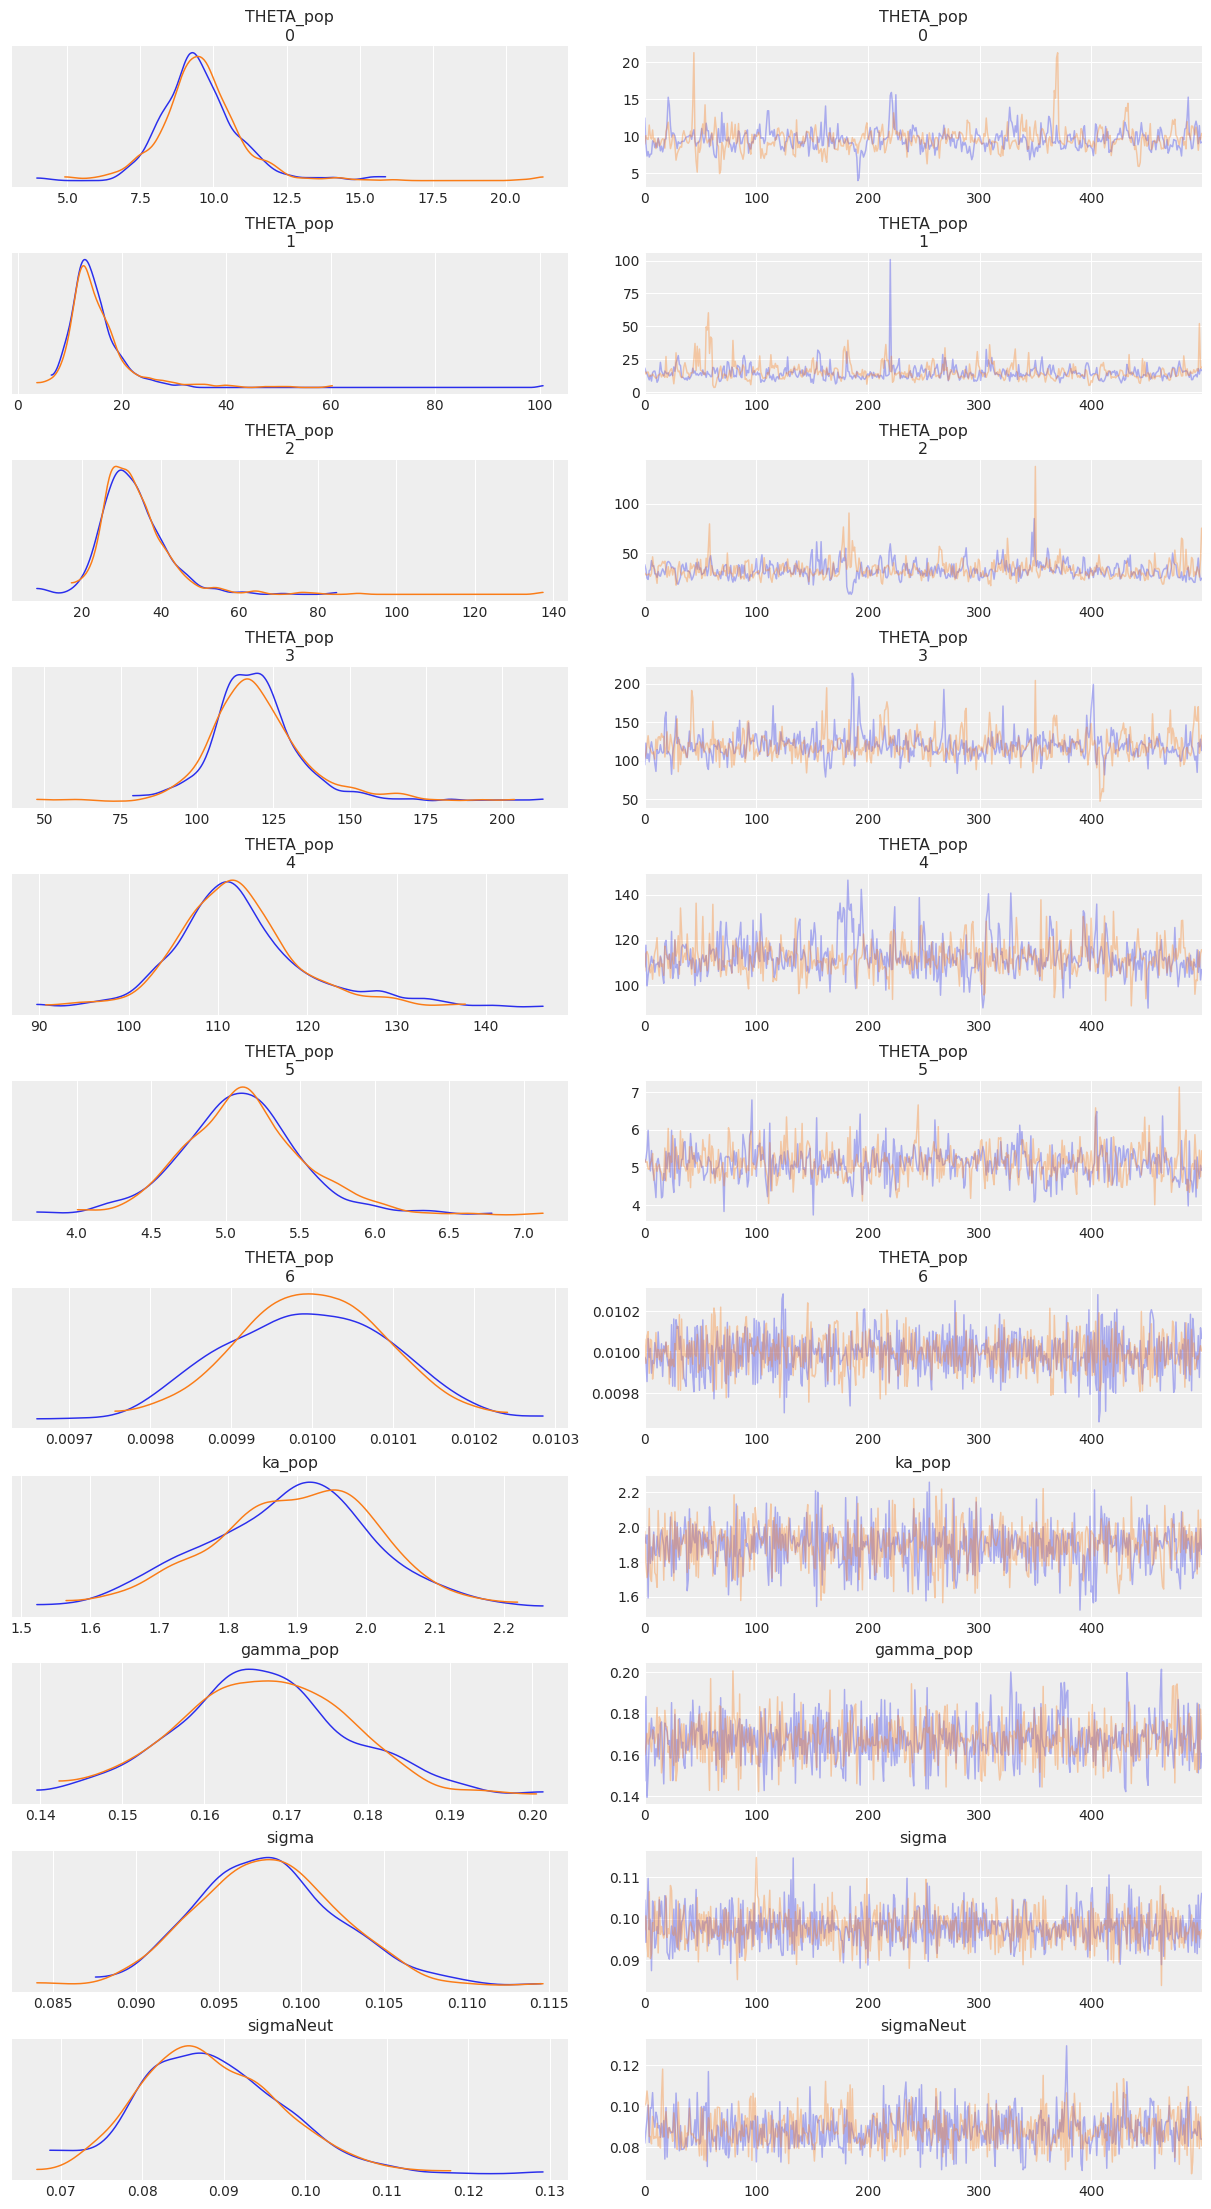

In [30]:
az.plot_trace(chains.posterior, var_names=['THETA_pop', 'ka_pop', 'gamma_pop', 'sigma', 'sigmaNeut'], compact=False) ;

### PPC

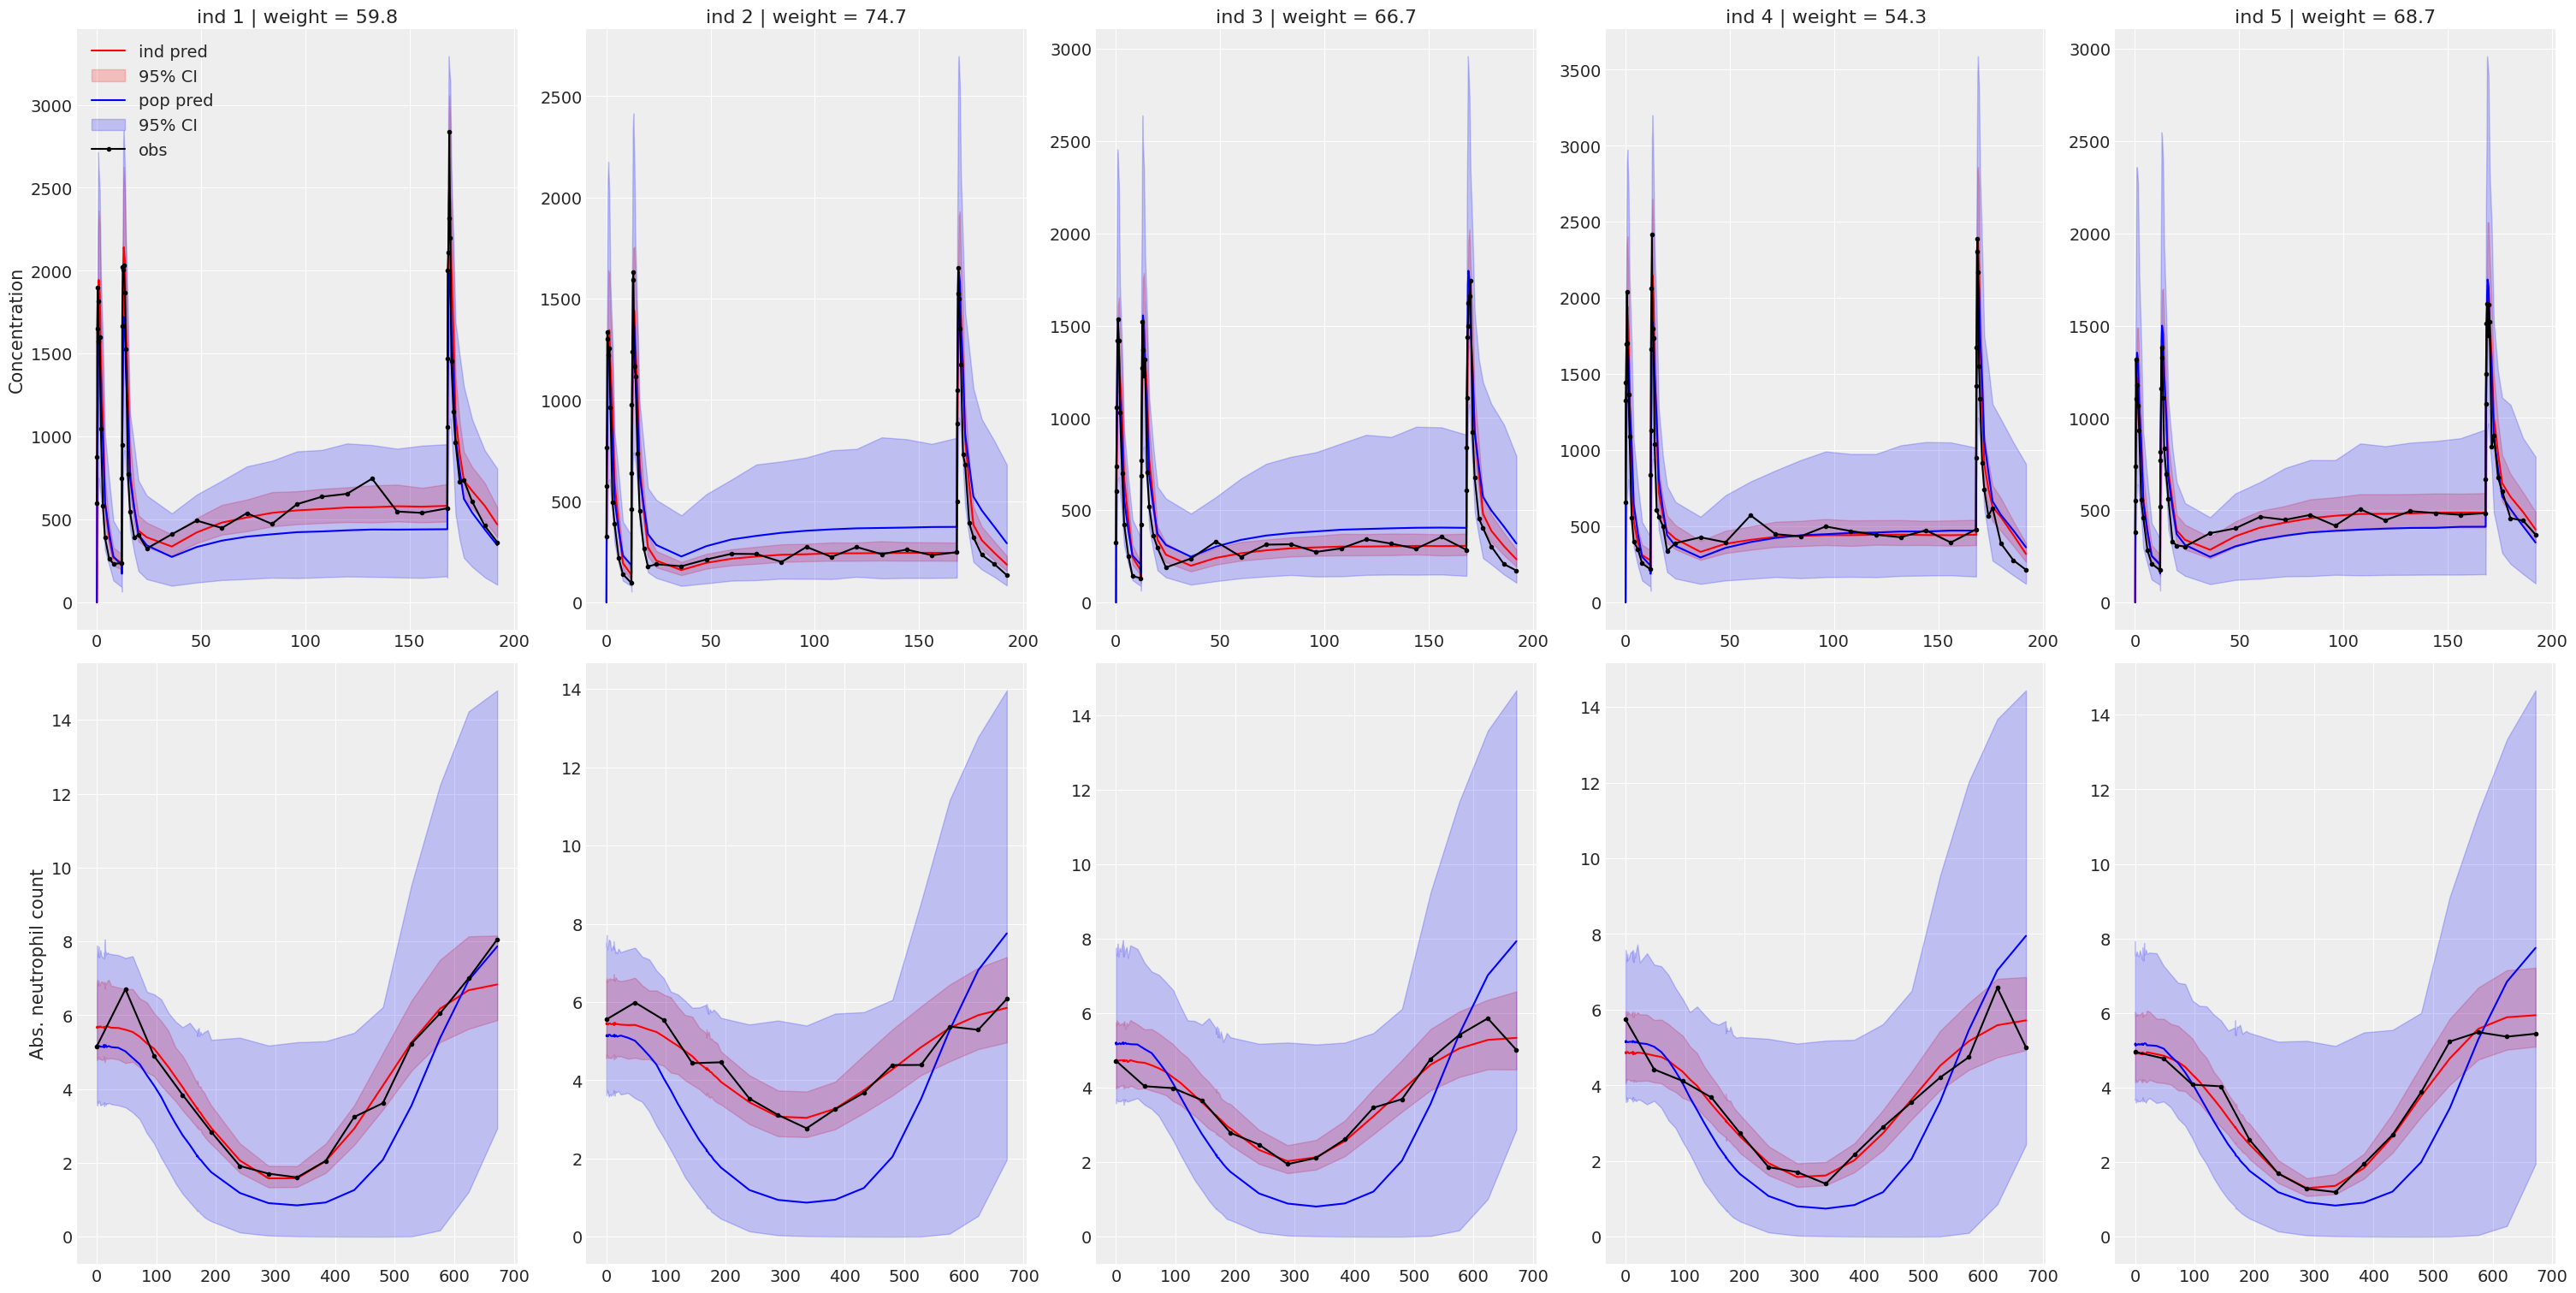

In [68]:
plot_ppc_az(chains, 5, figsize=(30, 15))

### Prior vs Posterior distributions

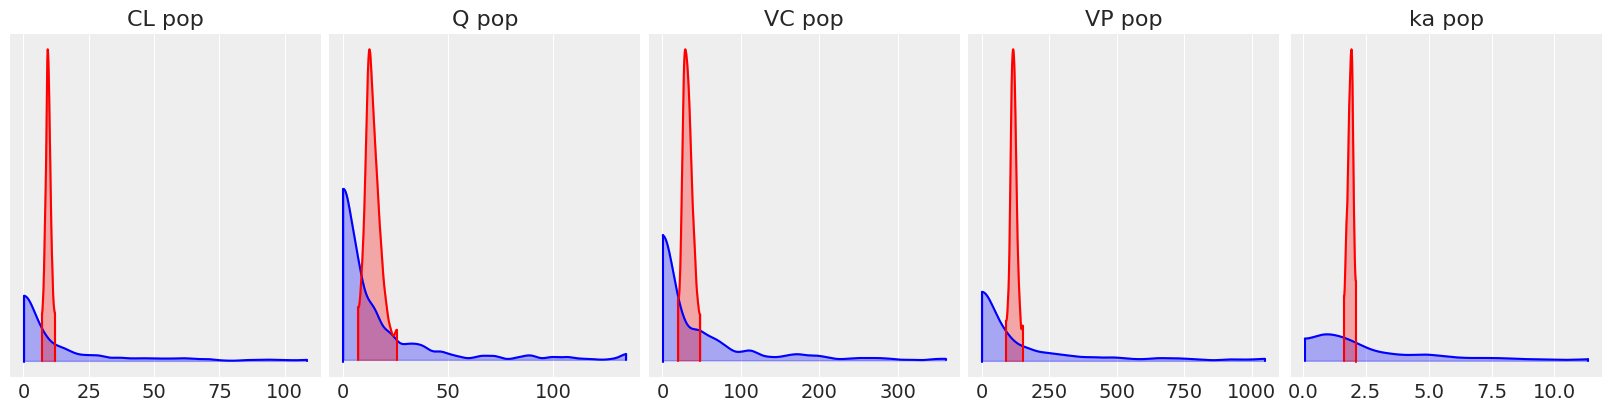

In [83]:
PK_prior = [CLpop_prior, Qpop_prior, VCpop_prior, VPpop_prior, kapop_prior]
PK_post = [chains.posterior['THETA_pop'][:, :, i].values for i in range(4)]
PK_post.append([])
PK_post[4] = chains.posterior['ka_pop'].values

plot_compare(PK_prior, PK_post, names=['CL pop', 'Q pop', 'VC pop', 'VP pop', 'ka pop'])

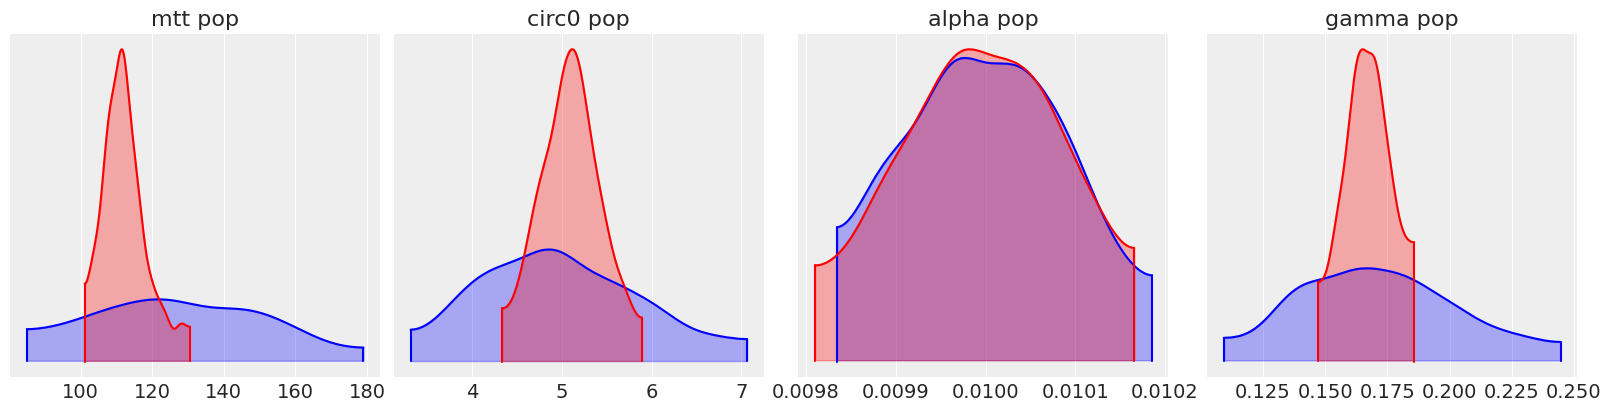

In [96]:
PD_prior = [mttpop_prior, circ0pop_prior, alphapop_prior, gammapop_prior]
PD_post = [chains.posterior['THETA_pop'][:, :, i].values for i in range(4, 7)]
PD_post.append([])
PD_post[3] = chains.posterior['gamma_pop'].values

plot_compare(PD_prior, PD_post, names=['mtt pop', 'circ0 pop', 'alpha pop', 'gamma pop'])